<img src='../img/EU-Copernicus-EUM_3Logos.png' alt='Logo EU Copernicus EUMETSAT' align='right' width='50%'></img>
<br>

# CAMS EAC4 Global Reanalysis Data - PM 2.5 time series

This notebook provides an introduction to the [CAMS EAC4 global reanalysis data](https://ads.atmosphere.copernicus.eu/cdsapp#!/dataset/cams-global-reanalysis-eac4) and shows you how the variable `Particulate matter d < 2.5 µm (PM2.5)` can be used to monitor air quality.

EAC4 (ECMWF Atmospheric Composition Reanalysis 4) is the fourth generation ECMWF global reanalysis of atmospheric composition. Reanalysis combines model data with observations from across the world into a globally complete and consistent dataset using a model of the atmosphere based on the laws of physics and chemistry. This principle, called data assimilation, is based on the method used by numerical weather prediction centres and air quality forecasting centres, where every so many hours (12 hours at ECMWF) a previous forecast is combined with newly available observations in an optimal way to produce a new best estimate of the state of the atmosphere, called analysis, from which an updated, improved forecast is issued. 

This notebook will calculate a time series of PM 2.5 data for Kuala Lumpur, Malaysia between 2019 and 2020.

### Basic Facts

> **Spatial resolution**: `0.75° x 0.75°` <br>
> **Spatial coverage**: `Global` <br>
> **Temporal resolution**:  `3-hourly` <br>
> **Temporal coverage**: `since 2015 to 2021` <br>
> **Data format**: `GRIB` or `NetCDF`


### How to access the data

CAMS EAC4 Global Reanalysis data are available for download via the [Copernicus Atmosphere Data Store (ADS)](https://ads.atmosphere.copernicus.eu/). You will need to create an ADS account [here](https://ads.atmosphere.copernicus.eu/user/register).

Data from the ADS can be downloaded in two ways:
* `manually` via the [ADS web interface](https://ads.atmosphere.copernicus.eu/cdsapp#!/dataset/cams-global-atmospheric-composition-forecasts?tab=overview)
* `programmatically` with a Python package called cdsapi ([more information](https://ads.atmosphere.copernicus.eu/api-how-to))

<hr>

##### Load required libraries

In [15]:
%matplotlib inline
import os
import xarray as xr
import numpy as np
import netCDF4 as nc
import pandas as pd

from IPython.display import HTML

import matplotlib.pyplot as plt
import matplotlib.colors
from matplotlib.cm import get_cmap
from matplotlib import animation
import cartopy.crs as ccrs
from cartopy.mpl.gridliner import LONGITUDE_FORMATTER, LATITUDE_FORMATTER
import cartopy.feature as cfeature

from matplotlib.axes import Axes
from cartopy.mpl.geoaxes import GeoAxes
GeoAxes._pcolormesh_patched = Axes.pcolormesh

import wget

import warnings
warnings.simplefilter(action = "ignore", category = RuntimeWarning)

##### Load helper functions

In [16]:
%run ../functions.ipynb

<hr>

### <a id='select_lat_lon'></a>1. Select latitude / longitude values for Kuala Lumpur, Malaysia

In [17]:
lat = 3.1390
lon = 101.6869

<br>

### <a id='cams_cdsapi_global'></a>*Optional: Retrieve CAMS global atmospheric composition forecasts programmatically*

The `CDS Application Program Interface (CDS API)` is a Python library which allows you to access data from the ADS `programmatically`. In order to use the CDS API, follow the steps below:

* [Self-register](https://ads.atmosphere.copernicus.eu/#!/home) at the ADS registration page (if you do not have an account yet)
* [Login](https://ads.atmosphere.copernicus.eu/user/login) to the ADS portal and go to the [api-how-to page](https://ads.atmosphere.copernicus.eu/api-how-to)
* Copy the CDS API key displayed in the black terminal window and replace the `######` of the `KEY` variable below with your individual CDS API key

**Note:** You find your CDS API key displayed in the black terminal box under the section `Install the CDS API key`. If you do not see a URL or key appear in the black terminal box, please refresh your browser tab. 

In [4]:
URL='https://ads.atmosphere.copernicus.eu/api/v2'
KEY='###############################'

The next step is then to request the data with a so called `API request`. Via the [ADS web interface](https://ads.atmosphere.copernicus.eu/cdsapp#!/dataset/cams-global-atmospheric-composition-forecasts?tab=form), you can select the data and at the end of the web interface, you can open the ADS request via `Show API request`. Copy the request displayed there in the cell below. Once you execute the cell, the download of the data starts automatically.

First, we have to download the `CAMS global reanalysis (EAC4)` from the [Copernicus Atmosphere Data Store](https://ads.atmosphere.copernicus.eu/cdsapp#!/dataset/cams-global-reanalysis-eac4?tab=form) with the following specifications:
* Variable on single levels: `Particulate matter d < 2.5 µm (PM2.5)`
* Date: `Start=2019-01-01`, `End=2020-12-31`
* Time: `[00:00, 03:00, 06:00, 09:00, 12:00, 15:00, 18:00, 21:00]`
* Restricted area: `N: 10., W: 110, E: 120, S: -10.`
* Format: `netCDF`

See `CDSAPI` request below.

In [5]:
import cdsapi

c = cdsapi.Client()

c.retrieve(
    'cams-global-reanalysis-eac4',
    {
        'format': 'netcdf',
        'variable': 'particulate_matter_2.5um',
        'date': '2019-01-01/2020-12-31',
        'time': [
            '00:00', '03:00', '06:00',
            '09:00', '12:00', '15:00',
            '18:00', '21:00',
        ],
        'area': [
            10, 110, -10,
            120,
        ],
    },
    '2019_2020_cams_reanalysis_pm2p5.nc')

2022-03-23 06:36:01,794 INFO Welcome to the CDS
2022-03-23 06:36:01,797 INFO Sending request to https://ads.atmosphere.copernicus.eu/api/v2/resources/cams-global-reanalysis-eac4
2022-03-23 06:36:02,266 INFO Request is completed
2022-03-23 06:36:02,268 INFO Downloading https://download-0001.copernicus-atmosphere.eu/cache-compute-0001/cache/data4/adaptor.mars.internal-1647531174.9252753-14736-14-4007da41-43be-467b-996b-a84efd10671b.nc to 2019_2020_cams_reanalysis_pm2p5.nc (4.2M)
2022-03-23 06:36:02,901 INFO Download rate 6.7M/s   


Result(content_length=4445824,content_type=application/x-netcdf,location=https://download-0001.copernicus-atmosphere.eu/cache-compute-0001/cache/data4/adaptor.mars.internal-1647531174.9252753-14736-14-4007da41-43be-467b-996b-a84efd10671b.nc)

### <a id='open_data'></a>2. Open the downloaded CAMS netCDF data file 

The data is in netCDF, so we can open the netCDF file with the xarray function `open_dataset()`. We see that the data has three dimensions (`latitude`, `longitude`, `time`) and one data variable:
* `pm2p5`: Particulate matter d < 2.5 µm (PM2.5)

In [18]:
file = xr.open_dataset('../eodata/cams/reanalysis/2019_2020_cams_reanalysis_pm2p5.nc')
file

<xarray.Dataset>
Dimensions:    (longitude: 14, latitude: 27, time: 5848)
Coordinates:
  * longitude  (longitude) float32 110.0 110.8 111.5 112.2 ... 118.2 119.0 119.8
  * latitude   (latitude) float32 9.5 8.75 8.0 7.25 ... -7.75 -8.5 -9.25 -10.0
  * time       (time) datetime64[ns] 2019-01-01 ... 2020-12-31T21:00:00
Data variables:
    pm2p5      (time, latitude, longitude) float32 ...
Attributes:
    Conventions:  CF-1.6
    history:      2022-03-17 15:33:06 GMT by grib_to_netcdf-2.24.2: /opt/ecmw...

<br>

Let us now store the data variable `Particulate matter d < 2.5 µm (PM2.5)` as `xarray.DataArray` with the name `pm2p5_cams`.

In [19]:
pm2p5_cams = file['pm2p5']
pm2p5_cams

<xarray.DataArray 'pm2p5' (time: 5848, latitude: 27, longitude: 14)>
[2210544 values with dtype=float32]
Coordinates:
  * longitude  (longitude) float32 110.0 110.8 111.5 112.2 ... 118.2 119.0 119.8
  * latitude   (latitude) float32 9.5 8.75 8.0 7.25 ... -7.75 -8.5 -9.25 -10.0
  * time       (time) datetime64[ns] 2019-01-01 ... 2020-12-31T21:00:00
Attributes:
    units:          kg m**-3
    long_name:      Particulate matter d <= 2.5 um
    standard_name:  mass_concentration_of_pm2p5_ambient_aerosol_particles_in_air

<br>

Now, we can select the time-series of the grid point nearest to Kuala Lumpur. We can use the function `sel()` to select data based on the longitude and latitude dimensions. The keyword argument `method='nearest'` selects the grid point entry closest to the city's coordinates.

In [20]:
cams_ts = pm2p5_cams.sel(longitude=lon, latitude=lat, method='nearest')
cams_ts

<xarray.DataArray 'pm2p5' (time: 5848)>
array([2.151228e-08, 1.998183e-08, 1.938656e-08, ..., 5.314291e-09,
       6.802338e-09, 7.014933e-09], dtype=float32)
Coordinates:
    longitude  float32 110.0
    latitude   float32 3.5
  * time       (time) datetime64[ns] 2019-01-01 ... 2020-12-31T21:00:00
Attributes:
    units:          kg m**-3
    long_name:      Particulate matter d <= 2.5 um
    standard_name:  mass_concentration_of_pm2p5_ambient_aerosol_particles_in_air

<br>

The next step is now to resample the 3-hourly time entries and aggregate it to daily averages. We can use a combination of the functions `resample()` and `mean()` to create daily averages.

In [21]:
cams_ts_resample = cams_ts.resample(time='1D').mean()
cams_ts_resample

<xarray.DataArray 'pm2p5' (time: 731)>
array([1.73087074e-08, 1.28978286e-08, 4.49590232e-09, 7.23808569e-09,
       5.82446091e-09, 8.92804053e-09, 7.43473549e-09, 8.98650399e-09,
       7.07865411e-09, 1.04001003e-08, 1.04851381e-08, 7.43473549e-09,
       9.98026906e-09, 8.28501356e-09, 7.38157269e-09, 4.62877381e-09,
       1.12610081e-08, 1.37428060e-08, 1.08411911e-08, 1.24514514e-08,
       1.08783809e-08, 1.38118850e-08, 1.74947132e-08, 1.55974931e-08,
       1.48960169e-08, 9.82083748e-09, 8.19997581e-09, 1.05010542e-08,
       1.38544038e-08, 1.06605000e-08, 7.44532258e-09, 8.24780955e-09,
       1.03788409e-08, 1.10112381e-08, 1.05223279e-08, 5.78197046e-09,
       8.30095814e-09, 4.70313921e-09, 4.88917351e-09, 4.88385865e-09,
       7.17962223e-09, 7.29122007e-09, 8.92271146e-09, 9.78364767e-09,
       6.89266244e-09, 5.95731819e-09, 6.63756339e-09, 8.56665849e-09,
       3.58714658e-09, 1.09208997e-08, 5.33556488e-09, 9.25751920e-09,
       6.03171202e-09, 8.07244760e-09, 8.04054423e-09, 7.66853248e-09,
       9.45945544e-09, 8.43381542e-09, 8.02461386e-09, 8.23185076e-09,
       6.06894446e-09, 7.49315632e-09, 5.65971447e-09, 8.01929900e-09,
       1.14842180e-08, 3.35863604e-09, 8.57197335e-09, 1.11599263e-09,
       1.45611523e-09, 8.17871637e-09, 1.38702205e-09, 7.89707144e-09,
       8.35406411e-09, 1.25417756e-08, 1.04107301e-08, 7.60475416e-09,
       7.88111265e-09, 3.40645556e-09, 2.99725400e-09, 2.54553356e-09,
...
       1.12025447e-08, 9.39037648e-09, 1.21166295e-08, 8.27436963e-09,
       1.36577682e-08, 3.66685526e-09, 4.76161688e-09, 6.01581007e-09,
       1.02194377e-08, 9.02899444e-09, 7.40816120e-09, 4.25676205e-09,
       1.25895951e-08, 7.63132846e-09, 5.70757663e-09, 5.21863797e-09,
       3.22046390e-09, 7.16367765e-09, 6.05298567e-09, 6.86075907e-09,
       6.86607393e-09, 5.71819214e-09, 8.61980709e-09, 1.69525549e-09,
       3.45960416e-09, 7.27528970e-09, 7.03614944e-09, 1.01503304e-08,
       2.99726821e-09, 3.71468900e-09, 5.45247758e-09, 6.59504451e-09,
       5.34619460e-09, 3.13011128e-09, 5.37275469e-09, 4.45336923e-09,
       5.35682432e-09, 3.14074100e-09, 4.98481256e-09, 3.32141781e-09,
       2.97069391e-09, 4.41617942e-09, 5.19739274e-09, 4.34708625e-09,
       6.77573553e-09, 6.00516614e-09, 6.79699497e-09, 5.37809797e-09,
       3.89007937e-09, 3.86881993e-09, 4.27803570e-09, 7.02020486e-09,
       1.15426673e-08, 1.37056162e-08, 3.68279984e-09, 6.56315535e-09,
       8.71544614e-09, 4.99011321e-09, 3.39584005e-09, 5.99985128e-09,
       1.12291190e-08, 6.75979095e-09, 7.28590521e-09, 4.30991065e-09,
       5.69693270e-09, 4.16642365e-09, 8.49757953e-09, 1.19784573e-08,
       1.67028702e-08, 8.00865507e-09, 6.52065069e-09, 2.98663849e-09,
       6.99894542e-09, 5.02733144e-09, 7.34436867e-09, 5.66505776e-09,
       6.73323086e-09, 7.38687334e-09, 4.91574781e-09], dtype=float32)
Coordinates:
  * time       (time) datetime64[ns] 2019-01-01 2019-01-02 ... 2020-12-31
    longitude  float32 110.0
    latitude   float32 3.5

<br>

A closer look at the `time` dimension shows us that we now have an entry for each day in 2019 and 2020.

In [11]:
cams_ts_resample.time

<xarray.DataArray 'time' (time: 731)>
array(['2019-01-01T00:00:00.000000000', '2019-01-02T00:00:00.000000000',
       '2019-01-03T00:00:00.000000000', ..., '2020-12-29T00:00:00.000000000',
       '2020-12-30T00:00:00.000000000', '2020-12-31T00:00:00.000000000'],
      dtype='datetime64[ns]')
Coordinates:
  * time       (time) datetime64[ns] 2019-01-01 2019-01-02 ... 2020-12-31
    longitude  float32 110.0
    latitude   float32 3.5

<br>

Now, we can convert the `xarray.DataArray` to a `pandas.DataFrame`, as pandas is more efficient to handle time-series data. The function `to_dataframe()` easily converts a data array to a dataframe. The resulting dataframe has 366 rows and 3 columns.

In [22]:
cams_ts_df = cams_ts_resample.to_dataframe()
cams_ts_df

longitude  latitude         pm2p5
time                                         
2019-01-01      110.0       3.5  1.730871e-08
2019-01-02      110.0       3.5  1.289783e-08
2019-01-03      110.0       3.5  4.495902e-09
2019-01-04      110.0       3.5  7.238086e-09
2019-01-05      110.0       3.5  5.824461e-09
...               ...       ...           ...
2020-12-27      110.0       3.5  7.344369e-09
2020-12-28      110.0       3.5  5.665058e-09
2020-12-29      110.0       3.5  6.733231e-09
2020-12-30      110.0       3.5  7.386873e-09
2020-12-31      110.0       3.5  4.915748e-09

[731 rows x 3 columns]

Let us save the pandas dataframe as csv file. This allows us to easily load the time-series again at a later stage. You can use the function `to_csv()` to save a pandas.DataFrame as csv.

In [23]:
cams_ts_df.to_csv("../eodata/cams/reanalysis/2019_2020_ts_cams_pm2p5.csv", index_label='time')

<br>

The last step is now to plot the pandas.DataFrame.

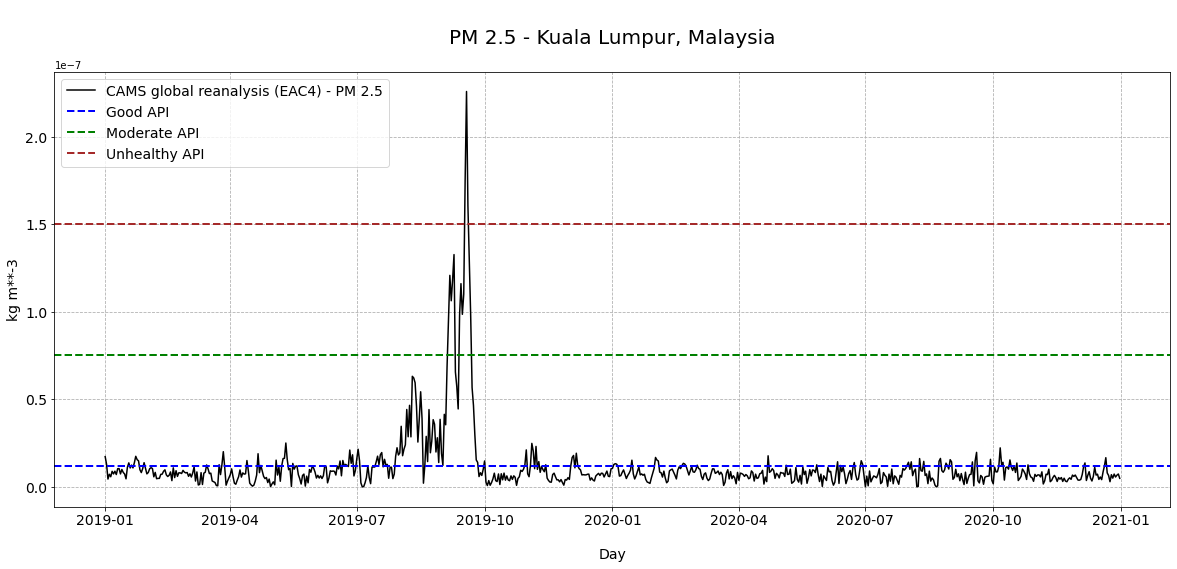

In [24]:
# Initiate a figure
fig = plt.figure(figsize=(20,8))
ax = plt.subplot()

# Define the plotting function
ax.plot(cams_ts_df.pm2p5, '-', color='black', label='CAMS global reanalysis (EAC4) - PM 2.5')
plt.axhline(y=12*1e-9, color='blue', linestyle='dashed', lw=2, label='Good API')
plt.axhline(y=75.5*1e-9, color='green', linestyle='dashed', lw=2, label='Moderate API')
plt.axhline(y=150.4*1e-9, color='brown', linestyle='dashed', lw=2, label='Unhealthy API')
#plt.axhline(y=250.4*1e-9, color='orange', linestyle='dashed', lw=2, label='Very Unhealthy API')
#plt.axhline(y=350.4*1e-9, color='red', linestyle='dashed', lw=2, label='Hazardous API')

# Customize the title and axes lables
ax.set_title('\nPM 2.5 - Kuala Lumpur, Malaysia\n', fontsize=20)
ax.set_ylabel(cams_ts.units, fontsize=14)
ax.set_xlabel('\nDay', fontsize=14)

# Customize the fontsize of the axes tickes
plt.xticks(fontsize=14)
plt.yticks(fontsize=14)

# Add a gridline to the plot
ax.grid(linestyle='--')

plt.legend(fontsize=14, loc=2)


The PM 2.5 spike in 2019 was due to haze from forest fires in Indonesia. There was no haze experienced in 2020, which was a La Nina year with higher precipitation levels. "API" stands for the [Air Pollution Index of Malaysia](http://apims.doe.gov.my/public_v2/aboutapi.html).

<br>

<hr>

<img src='../img/copernicus_logo.png' alt='Logo EU Copernicus' align='left' width='20%'><br><br><br><br>
<p style="text-align:right;">This project is licensed under the <a href="./LICENSE">MIT License</a> and is developed under a Copernicus contract.